In [1]:
import os
import gym
import pickle
import matplotlib.pyplot as plt
import numpy as np
import ppaquette_gym_doom
from collections import deque

In [2]:
# Create a classic Doom environment with Gym
env = gym.make('ppaquette/DoomDefendCenter-v0')

INFO:gym.envs.registration:Making new env: ppaquette/DoomDefendCenter-v0
[2017-05-01 21:54:56,325] Making new env: ppaquette/DoomDefendCenter-v0


In [3]:
class TDAgent():
    def __init__(self,\
               learn_rate=0.05,\
               observation_encoder=lambda x: x,\
               verbose=True):
        self.alpha = 1.0 # Degree of temporal difference
        self.policy = dict() # Vπ: action => state => v
        self.total_reward = 0
        self.learn_rate = learn_rate
        self.observation_encoder = observation_encoder
        self.action_mapping = {} # Map [action str] => [action object]
        self.history = deque() # List of (state, action, reward), first is newest
    
    def reset(self):
        self.history.clear()
    
    def learn_aggregate(self, observation, observation_, action, reward):
        # Encode [observation] => [state]
        state  = self.observation_encoder(observation)
        state_ = self.observation_encoder(observation_)
        self.history.appendleft((state, str(action), reward))
        self.action_mapping[str(action)] = action
        self.learn_V(state, str(action), reward, state_)
        
    """
    Find maximum possible reward we would get
    from the best action attempted on [state]
    """
    def find_best_action(self, state):
        best_return = -1
        best_action = -1
        # Find the best policy which applies on [state]
        # and it yields the highest [V]
        for action in self.policy:
            if state in self.policy[action]:
                if self.policy[action][state] > best_return:
                    best_action = action
                    best_return = self.policy[action][state]
        return (best_action, best_return)
    
    def decode_action(self, action):
        if action not in self.action_mapping:
          return None
        else: 
          return self.action_mapping[action]
    
    """
    Query the value policy V(state):π
    """
    def V(self, state, action):
        if action not in self.policy:
            self.policy[action] = {state: 0}
        if state not in self.policy[action]:
            self.policy[action][state] = 0
        return self.policy[action][state]

    """
    Update the value policy π
    """
    def learn_V(self, state, action, reward, next_state):
        old_V = self.V(state, action)
        new_V = self.V(next_state, action)
        
        # TAODEBUG:
        #print('[Learn V]')
        #print('... V : {:.2f}'.format(old_V))
        #print('... V`: {:.2f}'.format(new_V))
        
        self.policy[action][state] = old_V + \
            self.learn_rate * (reward + self.alpha * new_V - old_V)
    
    @staticmethod
    def load(path, default):
        if os.path.isfile(path):
          with open(path,'rb') as f:
            return pickle.load(f) 
        else:
          print('MODEL NOT FOUND, initialising a brand new one.')
          return default

    @staticmethod
    def save(path,agent):
        with open(path,'wb+') as f:
          return pickle.dump(agent, f)

In [4]:
# Computer vision utils
from PIL import Image
from scipy.stats import threshold
from scipy.signal import medfilt
from scipy.misc import toimage
def encode_screen(observation):
  # Crop & downsampling & grayscale
  cropped = observation[150:230:3, ::2 , :]
  r = cropped[:,:,0]
  return projection(pixelate(r))

def show(mat):
  toimage(mat).show()

"""
Coarse pixelate
"""
def pixelate(observation):
  # Threshold
  m = threshold(observation, threshmin=100, threshmax=None, newval=0)
  # Remove noise
  m = medfilt(m, 3)
  return m

def projection(pixels):
  # Horizontal projection
  _,w = pixels.shape
  proj = np.zeros(w)
  for x in range(w):
    proj[x] = np.where(np.sum(pixels[:,x]) < 2400, 1, 0)

  # Reduce
  pj = []
  count = np.count_nonzero
  start = 0
  stride = 5
  while len(proj[start:start+stride])>0:
    pj.append(count(proj[start:start+stride]) > 3)
    start += stride+1
    
  return str(pj)

In [5]:
# Play
model_name = 'TDAgent.pkl'
score_records = [] # Scores of each round
turn_records = [] # Number of turns lasting each round
num_episodes = 100
all_actions = set(range(3)) # Attack / Right / Left

bot = TDAgent.load(model_name,\
                  TDAgent(learn_rate=0.8, \
                         observation_encoder=encode_screen))

for i in range(num_episodes):
  if num_episodes<25 or i % 25 == 0:
    print('Ep#{} started...'.format(i))
  observation = env.reset()
  num_turns = 0
  while True:
    env.render()
    
    # Try to find best action, otherwise, random
    state = bot.observation_encoder(observation)
    if i < 0.75 * num_episodes:
      action = -1
    else:
      action, _ = bot.find_best_action(state)
    if action == -1:
      action = env.action_space.sample()
    else:
      # print('... Best action : ', action)
      action = bot.decode_action(action)

    observation_, reward, done, info = env.step(action)
    bot.learn_aggregate(observation, observation_, action, reward)
    observation = np.copy(observation_)
    num_turns  += 1
    if done:
      score_records.append(bot.total_reward)
      turn_records.append(num_turns)
      if num_episodes<25 or i % 25 == 0:
        print('...[DONE] Total reward : {}'.format(bot.total_reward))
      # Save the agent
      TDAgent.save(model_name, bot)
      bot.reset()
      break
        
print('All {} episodes of training are DONE.'.format(num_episodes))

Ep#0 started...
...[DONE] Total reward : 0
Ep#25 started...
...[DONE] Total reward : 0
Ep#50 started...
...[DONE] Total reward : 0
Ep#75 started...
...[DONE] Total reward : 0
All 100 episodes of training are DONE.


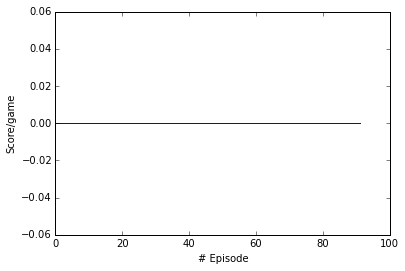

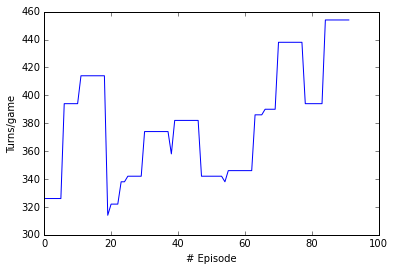

In [6]:
# Show score
%matplotlib inline

def moving_avg(arr):
  mm = []
  wnd = 8
  for i in range(len(arr)):
    v = arr[i-wnd:i]
    if len(v)>0:
      mm.append(max(v))
  return mm

plt.figure(1)
plt.xlabel('# Episode')
plt.ylabel('Score/game')
plt.plot(moving_avg(score_records))

plt.figure(2)
plt.xlabel('# Episode')
plt.ylabel('Turns/game')
plt.plot(moving_avg(turn_records))
plt.show()